In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [5]:
def ds(pos, center, sizes):
    return sizes - 0.04*np.sqrt(np.square(pos[0]-center[0])+np.square(pos[1]-center[1]))

def get_darkChannel(img, radii):

    # split the original image to three channels
    r, g, b = cv2.split(img)

    # get the image dark channel
    dc = cv2.min(cv2.min(r, g), b)

    # get the local area min value like erode in single channle image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radii, radii))
    dc = cv2.erode(dc, kernel)

    return dc

# Estimating the Atmospheric Light
def get_atmosphericLight(img, dc):

    # get the top 0.1% brightest pixels in the dark channel
    h, w = img.shape[:2]

    top_pixels = max(h*w // 1000, 1)
    dc_vec, img_vec = dc.reshape(h*w), img.reshape(h*w, 3)

    ind_pixels = np.argsort(dc_vec)[h*w-top_pixels:]
    
    # find the brightest pixels in the image
    A = np.zeros((3, ))
    A[0] = np.max(img_vec[ind_pixels][0])
    A[1] = np.max(img_vec[ind_pixels][1])
    A[2] = np.max(img_vec[ind_pixels][2])

    return A

def get_transmission(beta, d):
    return np.exp(-beta*d)

def foggy(img, params):

    # normalize the image
    res = img / 255.0

    # get the image size
    h, w, c = img.shape


    # traverse the img pixels
    for i in range(h):
        for j in range(w):
            d = ds([i, j], params['center'], params['size'])
            t = get_transmission(params['beta'], d)

            for l in range(c):
                res[i][j][l] = res[i][j][l] * t + params['Bright'][l] * params['gamma'] * (1 - t)
    return res


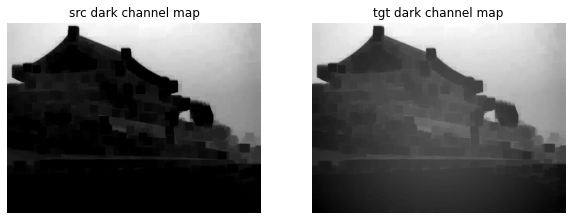

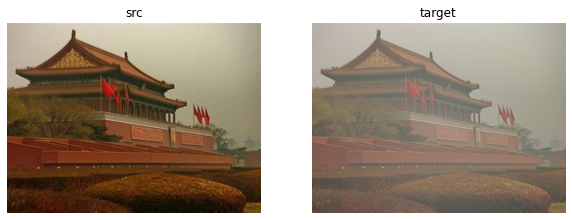

In [12]:
# test of the img
import os
import glob
filedir = '.'
filename = '*'
fileend = ['.jpg']
filepath = []
for end in fileend:
    files = glob.glob(os.path.join(filedir, filename+end))
    for file in files:
        filepath.append(file)



for img_path in filepath:
    src = cv2.imread(img_path)

    params = {
        'center': [src.shape[0] // 2, src.shape[1] // 2],
        'size': np.sqrt(max(src.shape[0], src.shape[1])),
        'Bright': get_atmosphericLight(src, get_darkChannel(src, 15)) / 255,
        'beta':0.04,
        'gamma': 0.8
    }
    target = foggy(src, params)

    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(get_darkChannel(src, 15), cmap='gray')
    plt.title('src dark channel map')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(get_darkChannel(target, 15), cmap='gray')
    plt.title('tgt dark channel map')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.imshow(src[:, :, ::-1])
    plt.title('src')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(target[:, :, ::-1])
    plt.title('target')
    plt.axis('off')
    plt.show()
